/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-28 13:20:52.852147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745839252.871807  501803 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745839252.877805  501803 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745839252.893380  501803 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:17458

Epoch [1/4], Training Loss: 1.0019
Validation Loss: 0.9110
Saved Best Model at Epoch 1
Epoch [2/4], Training Loss: 0.8018
Validation Loss: 0.9106
Saved Best Model at Epoch 2
Epoch [3/4], Training Loss: 0.6235
Validation Loss: 1.0012
Epoch [4/4], Training Loss: 0.4387
Validation Loss: 1.2176

Test Results:
Accuracy: 0.6124
Precision: 0.6161613355503842
Recall: 0.6124834726767763

Classification Report:
               precision    recall  f1-score   support

      1 Star       0.72      0.76      0.74      2010
      2 Star       0.52      0.63      0.57      2028
      3 Star       0.58      0.42      0.49      1994
      4 Star       0.54      0.57      0.55      2016
      5 Star       0.73      0.68      0.70      1952

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.62      0.61      0.61     10000



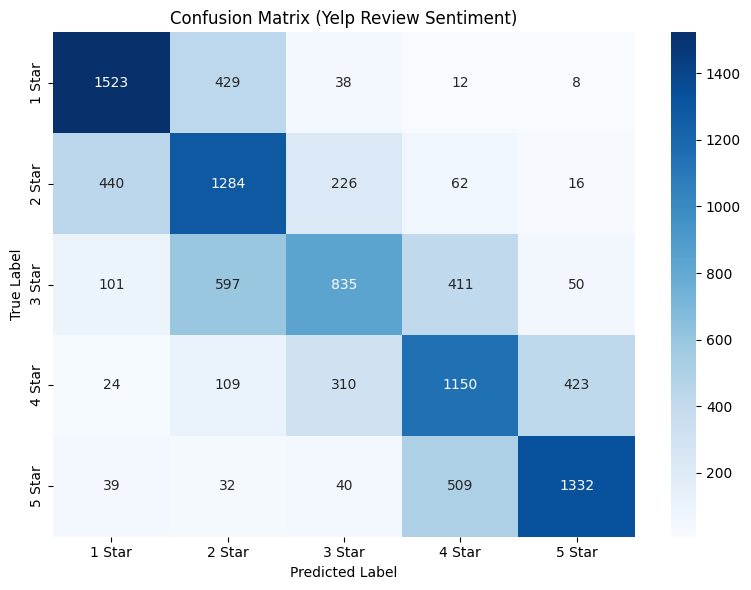

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Clear unused memory
torch.cuda.empty_cache()

class SentimentDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = str(self.sentences[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            sentence,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

if __name__ == "__main__":
    # Load Yelp dataset
    dataset = load_dataset("yelp_review_full")
    train_df = dataset["train"].to_pandas()
    test_df = dataset["test"].to_pandas()

    # Light preprocessing
    train_df["Sentence"] = train_df["text"].str.lower()
    test_df["Sentence"] = test_df["text"].str.lower()
    train_df["Class"] = train_df["label"]
    test_df["Class"] = test_df["label"]

    train_df = train_df[["Sentence", "Class"]]
    test_df = test_df[["Sentence", "Class"]]

    # Optional: Downsample for faster dev
    train_df = train_df.sample(50000, random_state=42)
    test_df = test_df.sample(10000, random_state=42)

    # Split into train/validation
    train_sentences, val_sentences, train_labels, val_labels = train_test_split(
        train_df['Sentence'].values, 
        train_df['Class'].values, 
        test_size=0.2, 
        random_state=42, 
        stratify=train_df['Class']
    )

    # Load BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create datasets and dataloaders
    max_len = 128
    batch_size = 16
    train_dataset = SentimentDataset(train_sentences, train_labels, tokenizer, max_len)
    val_dataset = SentimentDataset(val_sentences, val_labels, tokenizer, max_len)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Load BERT model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
    model = model.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

    # Optimizer
    optimizer = Adam(model.parameters(), lr=2e-5)

    # Training loop
    num_epochs = 4
    best_model = None
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['label'].to(model.device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        total_loss /= len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(model.device)
                attention_mask = batch['attention_mask'].to(model.device)
                labels = batch['label'].to(model.device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)
            print(f"Saved Best Model at Epoch {epoch+1}")

    # Prepare test set
    test_sentences = test_df['Sentence'].values
    test_labels = test_df['Class'].values
    test_dataset = SentimentDataset(test_sentences, test_labels, tokenizer, max_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Evaluate best model on test set
    best_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(best_model.device)
            attention_mask = batch['attention_mask'].to(best_model.device)
            labels = batch['label'].to(best_model.device)

            outputs = best_model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nTest Results:")
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("Precision:", precision_score(all_labels, all_preds, average='macro'))
    print("Recall:", recall_score(all_labels, all_preds, average='macro'))
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=[f"{i+1} Star" for i in range(5)]))
    # Confusion Matrix Plot
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1} Star" for i in range(5)],
            yticklabels=[f"{i+1} Star" for i in range(5)])
plt.title("Confusion Matrix (Yelp Review Sentiment)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("bert_yelp_confusion_matrix.png")
plt.show()